### Omni Recognition with Qwen3-VL

By improving the quality and diversity of pre-training data, the model can now recognize a much wider range of objects — from celebrities, anime characters, products, and landmarks, to animals and plants — covering both everyday life and professional “recognize anything” needs.

This notebook demonstrates how to use Qwen3-VL for omni recognition. It takes an image and a query, and then uses the model to interpret the user's query on the image. 

!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install qwen_agent
!pip install openai#### \[Setup\]

Load plotting and inference util.

In [ ]:
import json
import random
from PIL import Image, ImageDraw, ImageFont
from openai import OpenAI
import os
import base64
import requests
import oss2
import copy
import traceback
import time
import torch
from oss2.credentials import EnvironmentVariableCredentialsProvider

# inference with api
DASHSCOPE_API_KEY = os.environ.get('DASHSCOPE_API_KEY', 'empty')

CALL_URL = 'https://dashscope-intl.aliyuncs.com/compatible-mode/v1'
HEADERS = {
    'Content-Type': 'application/json',
    "Authorization": f"Bearer {DASHSCOPE_API_KEY}"
}

def dash_call(**kwargs):
    payload = copy.deepcopy(kwargs)
    assert 'model' in payload
    max_try = 10
    for i in range(max_try):
        try:
            ret = requests.post(CALL_URL, json=payload,
                                headers=HEADERS, timeout=180)
            if ret.status_code != 200:
                raise Exception(f"http status_code: {ret.status_code}\n{ret.content}")
            ret_json = ret.json()
            gen_content = ret_json.get("output", {}).get("choices", [{}])[0].get("message", {}).get("content", "")
            result = ''.join(output.get('text', '') for output in gen_content if 'text' in output)
            return result
            # for output in ret_json['choices']:
            #     if output['finish_reason'].lower() not in ['stop', 'function_call', 'prohibited_content']:
            #         raise Exception(f'openai finish with error...\n{ret_json}')
            # return ret_json['choices'][0]['message']['content']
        except Exception as e:
            print(traceback.format_exc())
            time.sleep(10)
    raise Exception('Max Retry!!!')

def inference_with_api(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=1024):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "image": img_url
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]
    kwargs = dict(
        model='qwen3-vl-235b-a22b-instruct',
        input={"messages": messages}
        # messages=messages,
        # max_completion_tokens=max_new_tokens,
        # stream=False,
    )
    try:
        model_response = dash_call(**kwargs)
    except Exception as e:
        print(e)
        return None
    print(model_response)
    return model_response

def inference_with_openai_api(img_url, prompt, min_pixels=64 * 32 * 32, max_pixels=9800* 32 * 32):
    import base64
    import os
    if os.path.exists(img_url):
        with open(img_url, "rb") as image_file:
            base64_image = base64.b64encode(image_file.read()).decode("utf-8")
    elif img_url.startswith("http://") or img_url.startswith("https://"):
        response = requests.get(img_url)
        response.raise_for_status()
        base64_image = base64.b64encode(response.content).decode("utf-8")
    else:
        raise ValueError("Invalid image URL")
    client = OpenAI(
        api_key = DASHSCOPE_API_KEY,
        base_url = CALL_URL
    )
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model="pre-qwen3vl-235A22-instruct-0918-model",  # 此处以qwen-vl-max-latest为例，可按需更换模型名称。模型列表：https://help.aliyun.com/zh/model-studio/models
        messages=messages,
    )
    return completion.choices[0].message.content    


#### 1. Object Recognition

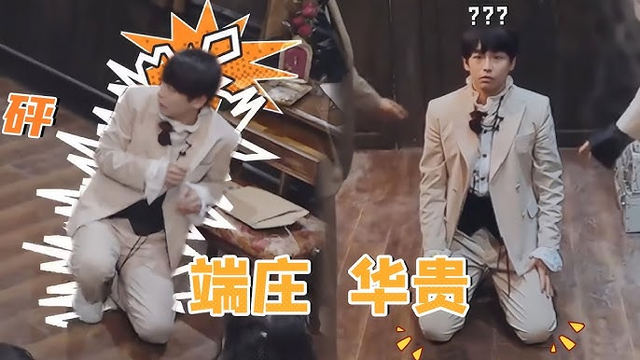

This is **Peng Yuchang (彭昱畅)**, a popular Chinese actor.

The image is a humorous meme-style split-screen:

- **Left side**: He’s kneeling dramatically, with comic “BANG!” effects and the Chinese character **“砰”** (pēng — sound of a bang/thud), suggesting a sudden, exaggerated collapse or fall. The text **“端庄 华贵”** (duān zhuāng huá guì — dignified and elegant) is ironically overlaid, contrasting with his chaotic pose.

- **Right side**: He’s kneeling calmly, looking confused with **“???”** above his head — a classic meme expression of bewilderment.

This meme likely originates from a variety show or behind-the-scenes clip where Peng Yuchang was caught in a funny, unplanned moment — perhaps falling while trying to be graceful, then reacting with confusion. His expressive face and comedic timing make him a frequent subject of internet memes in China.

Peng Yuchang is known for his roles in films and TV dramas like *The Untamed* (as the young Wei Wuxian), *The Island*, *My Love*, and *The

In [ ]:
image_path = "assets/omni_recognition/sample-celebrity-2.jpg"
prompt = "Who is this"

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
display(image)

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# print(response)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
response = inference_with_openai_api(image_path, prompt)
print(response)

#### 2 Object Spotting

With this update, we can now identify multiple objects in an image and find their coordinates.
Note that we use relative coordinates, and the coordinates are scaled from 0 to 1000.

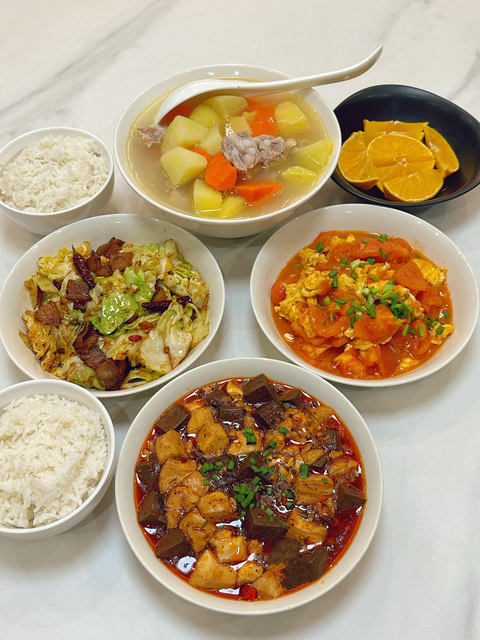

```json
[
	{"bbox_2d": [0, 614, 224, 825], "name_zh": "米饭", "name_en": "Rice"},
	{"bbox_2d": [0, 207, 227, 333], "name_zh": "米饭", "name_en": "Rice"},
	{"bbox_2d": [266, 126, 695, 343], "name_zh": "土豆胡萝卜排骨汤", "name_en": "Potato Carrot Pork Rib Soup"},
	{"bbox_2d": [704, 185, 956, 317], "name_zh": "橙子片", "name_en": "Orange Slices"},
	{"bbox_2d": [40, 368, 436, 610], "name_zh": "手撕包菜", "name_en": "Shredded Cabbage"},
	{"bbox_2d": [562, 359, 946, 593], "name_zh": "西红柿炒鸡蛋", "name_en": "Tomato Scrambled Eggs"},
	{"bbox_2d": [278, 584, 762, 939], "name_zh": "麻辣血豆腐", "name_en": "Spicy Blood Tofu"}
]
```


In [20]:
image_path = "./assets/omni_recognition/sample-food.jpeg"
prompt = "Identify food in the image and return their bounding box and Chinese and English name in JSON format."

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
display(image)

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# print(response)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
response = inference_with_openai_api(image_path, prompt)
print(response)


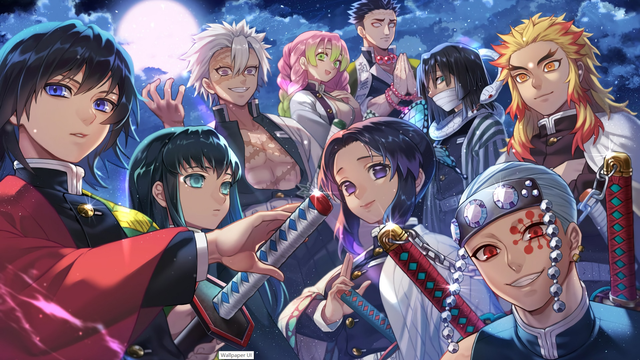

```json
[
	{
		"bbox_2d": [0, 52, 477, 999],
		"names": {
			"zh": "富冈义勇",
			"en": "Giyu Tomioka"
		}
	},
	{
		"bbox_2d": [197, 347, 520, 999],
		"names": {
			"zh": "时透无一郎",
			"en": "Muichiro Tokito"
		}
	},
	{"bbox_2d": [220, 54, 500, 595],
		"names": {
			"zh": "不死川实弥",
			"en": "Sanemi Shinazugawa"
		}
	},
	{
		"bbox_2d": [431, 84, 565, 401],
		"names": {
			"zh": "甘露寺蜜璃",
			"en": "Mitsuri Kanroji"
		}
	},
	{"bbox_2d": [541, 0, 667, 333],
		"names": {
			"zh": "悲鸣屿行冥",
			"en": "Gyomei Himejima"
		}
	},
	{
	{"bbox_2d": [649, 116, 794, 643],
		"names": {
			"zh": "伊黑小芭内",
			"en": "Obanai Iguro"
		}
	},
	{
		"bbox_2d": [762, 34, 999, 555],
		"names": {
			"zh": "炼狱杏寿郎",
			"en": "Kyojuro Rengoku"
		}
	},
	{
		"bbox_2d": [434, 322, 686, 999],
		"names": {
			"zh": "胡蝶忍",
			"en": "Shinobu Kocho"
		}
	},
	{
		"bbox_2d": [590, 444, 999, 999],
		"names": {
			"zh": "宇髓天元",
			"en": "Tengen Uzui"
		}
	}
]
```


In [17]:
image_path = "./assets/omni_recognition/sample-anime.jpeg"
prompt = "Who are the anime characters in the image? Please show the bounding boxes of all characters and their names in Chinese and English in JSON format."

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
display(image)

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# print(response)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
response = inference_with_openai_api(image_path, prompt)
print(response)